Sensor-1 Data length = 176401
Sensor-2 Data length = 176401

Mean of Sensor Data-1 = 0.000099
Mean of Sensor Data-2 = 0.001033

Standard Deviation of Sensor Data-1  = 0.266
Standard Deviation of Sensor Data-2  = 0.286

Cross Correlation = 0.001
Normalized Cross Correlation = 0.013

max correlation is at lag -50082

Freq. = 44000
Off-Set = -50082
Off-Set Time = -1.136

Distance between two sensors = 378.17 meters

Run time = 3.01


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:350: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


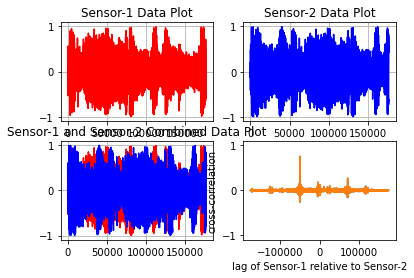

In [26]:
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from itertools import islice

#cache dictionary
product_cache = {}

#version 2
#Added functions to improve computation time 
#1
def CalcMean(lst):
    Sum = 0
    for i in range(0,len(lst)):
        Sum = Sum + lst[i]
    Mean = Sum/len(lst)    
    return(Mean)

#2
def CalcSD(lst,Mean):
    SD = 0
    for i in range(0,len(lst)):
        SD = SD + (lst[i]-Mean)*(lst[i]-Mean)
    SD = math.sqrt(SD/len(lst))        
    return(SD)    

#3
def CalcCrossCorr(f,g,fmean,gmean):
    Sum=0
    for i in range(0,len(f)):
        Sum = Sum + (f[i]-fmean)*(g[i]-gmean)
    CrossCorr = Sum/len(f)
    return(CrossCorr)

#4    
def CalcNormalisedCrossCorr(f,g,fmean,gmean,fsd,gsd):
    Sum = 0
    for i in range(0,len(f)):
        Sum = Sum + (f[i]-fmean)*(g[i]-gmean)
    NormCrossCorr = Sum/(len(f)*fsd*gsd)
    return(NormCrossCorr)


def calculate_energy( p, t, offset, len_p ): # - memoise 
    """
    Normalisation for 1D slice of N size array of same length of pattern passed.
    norm= sqrt( sum(f[i]^2) * sum(g[m]^2) )
 
    Inputs:
    ----------------
        p   Pattern must be non empty and sum-square of its elements precalculated and passed

        t   Template with similar dimensionality to pattern

        offset  Offset position in the template/search array

        len_p   offset for end-of-slice index for the slice of template
        
    Output:
    ----------------
        norm  Scalar float of variance for a given slice of the template/search and pattern
     """
    g_slice = t[ offset : offset + len_p ] 
    norm = np.sqrt( p * ( g_slice**2).sum() ) 
    # if norm == 0 :
    #     print ("p=", p, "template=", g_slice, "offset = ", offset, "\n")
    return norm


def calculate_score( pattern, template, offset):
    """
    Correlation for 1D slice of N size template/search array with pattern at given offset. Sum(f[i]*g[i+m])
 
    Inputs:
    ----------------
        pattern   Pattern must be non empty and sum-square of its elements precalculated and passed

        template   Template with similar dimensionality to pattern

        offset  Offset position in the template/search array
        
    Output:
    ----------------
        score  Scalar float of correlation score between pattern and template slice
     """    
    #not faster 
    # slice_template = template[ offset : offset + len(pattern) ]
    # score  = np.dot( pattern, slice_template ) 
    #Mutltiply and add each element of the pattern and template
    score = 0 
    for i in range(len( pattern )):
        o = i + offset
        #try:
        if template[o] > 0 and pattern[i] > 0:
            score += pattern[ i ] * template[ o ]
        #except:
            #print( "Error line 26", pattern, template )

    return score



def zero_padding( pattern, template ):
    """
    Pad 1D template at begining and end of array with pattern length
 
    Inputs:
    ----------------
        pattern   Pattern must be non empty and sum-square of its elements precalculated and passed

        template   Template with similar dimensionality to pattern
        
    Output:
    ----------------
        template_padded  Padded template array 
     """    
    #Calculate pad size 
    pad = [ 0 ] * ( len( pattern ) - 1 )
    #Pad begining and end of temple -1 for first element
    template_padded = pad + list(template) + pad

    return template_padded


#function that finds the largest element and its index in an array
def find_best_match( score ):
    """
    Find max value in 1D array and its index
 
    Inputs:
    ----------------
        score   1D target array
        
    Output:
    ----------------
        max_element Max Element in the array

        index   Index of largest element 

     """       
    s = np.array( score )
    try:
        max_element = np.amax( s )
    except:
        print( "Line 45 Error", score )
    index = np.argmax( s )

    return max_element, index


def norm_cross_corr( pattern, template, debug = False ): #change later to signal 1 and 2 as inputs
    """
    Normed cross correlation of two 1D arrays
 
    Inputs:
    ----------------
        pattern   Pattern must be non empty 

        template   Template, search space with similar dimensionality to pattern
        
    Output:
    ----------------
        norm_scores  Normed cross correlation array
     """       

    #Pad and initalise arrays for calculation   
    template_padded = zero_padding( pattern, template )
    corr_len = len( template_padded ) - len( pattern )
    scores = [0] * ( corr_len )
    norm = [0] * ( corr_len ) 
    norm_scores = [0] * ( corr_len ) 
    #test = [0] * ( len( template ) - len( pattern ) )
    #t_start = time.time()
    
    #Precalculate pattern squared-sum and store, reduces calculation time by half 
    pattern_arr = np.array( pattern )
    pattern_sq_sum = ( pattern_arr**2 ).sum() #to use in norm - memoised values to reduce number of computations
    template_pad_arr = np.array( template_padded )
    
    #Find normed cross correlation from convolution of pattern with template array slices
    t_start = time.time()
    for i in range( len( scores ) ):
        t_step = time.time()
        scores[ i ] = calculate_score( pattern, template_padded, i)
        #print( scores )
        #Whenever the norm is zero, the cross correlation is not calculated 
        if  scores[i]!=0 : 
            norm[ i ] = calculate_energy( pattern_sq_sum, template_pad_arr, i, len(pattern))
            norm_scores[i] = scores[ i ]/norm[ i ]
        tn = time.time()
        if debug: print( f'{ i } step time =  { tn - t_step} run time =  { tn - t_start}')
        
        #print( "s=", scores,"\n", "n=", norm, "\n")

    return norm_scores


def find_offset( correlation_arr ): 
    """
    1D array offset index and value from  cross correlation 
 
    Inputs:
    ----------------
        correlation_arr   Calculated array of cross correlation coefficients 
        
    Output:
    ----------------
        (best_score, best_match)  Index of offset found from cross correlation
     """     

    best_score, best_match = find_best_match( correlation_arr )
    #print( best_match )

    # subtract padding: - (len - 1)
    return best_match - len( pattern ) + 1, best_score 



def read_file( fileName ):
    """
    Read input data file and filters for numerical values 
 
    Inputs:
    ----------------
        fileName   File path 
 
    Output:
    ----------------
        data_list  List of read of only numerical data values
    
    References:
        super9super9 bronze badges, et al. 
        “Read File from Line 2 or Skip Header Row.” 
        Stack Overflow, 1 May 1960, stackoverflow.com/questions/4796764/read-file-from-line-2-or-skip-header-row.    
    """  
    
    data = open( fileName ,"r") 
    data_list = [float(line.strip() ) for line in islice(data, 1, None)] 
    data.close()
         
    return data_list



#calculate signal offset for files in the local directory that are read into program

def main():

    debug = False
    use_SSD = True #Calculate using library functions and mean
    
    #Read signal data
    S1_Data = read_file( "sensor1Data.txt" ) 
    S2_Data = read_file( "sensor2Data.txt" )

    # print( len(S1_Data), len( S2_Data ) )

    #Debugging size for smaller runs 
    if debug:
        Count=100000
        t = []
        for c in range(0,Count):
            t.append(c+1) #Keep track of index position in loop
            S1_Data.append(float(S1_Data[c]))
            S2_Data.append(float(S2_Data[c]))
    else:
        pass


    print("Sensor-1 Data length = %d"%len(S1_Data))
    print("Sensor-2 Data length = %d"%len(S2_Data))


    #This method uses the mean and standard deviation to remove noise from the signal data
    if use_SSD: 
        time_start = time.time()

        S1_Mean = CalcMean( S1_Data )
        S2_Mean = CalcMean( S2_Data )

        S1_sdev = CalcSD( S1_Data, S1_Mean )
        S2_sdev = CalcSD( S2_Data, S2_Mean ) 

        CCR = CalcCrossCorr( S1_Data, S2_Data,S1_Mean, S2_Mean)
        NormCCR = CalcNormalisedCrossCorr( S1_Data, S2_Data, S1_Mean, S2_Mean, S1_sdev, S2_sdev)

        #Use library functions to find CCR
        npts = len( S1_Data )
        t = np.linspace(0, len(S1_Data ), npts)
        y1 = np.array( S1_Data )
        y2 = np.array( S2_Data )        
        ccov = np.correlate(y1 - y1.mean(), y2 - y2.mean(), mode='full')
        n_ccor = ccov / (npts * y1.std() * y2.std())

        t_total = time.time() - time_start

        print("\nMean of Sensor Data-1 = %f"%S1_Mean)
        print("Mean of Sensor Data-2 = %f"%S2_Mean)

        print("\nStandard Deviation of Sensor Data-1  = %.3f"%S1_sdev)
        print("Standard Deviation of Sensor Data-2  = %.3f"%S2_sdev)

        print("\nCross Correlation = %.3f"%CCR)
        print("Normalized Cross Correlation = %.3f"%NormCCR)


    #Do without SSD
    else:
        time_start = time.time()
        size = len(S1_Data)
        n_ccor = norm_cross_corr( S1_Data[:size], S2_Data[:size], debug )
        
        offset, NormCCR = find_offset( n_ccor )
        
        t_total = time.time() - time_start


    #Plots of results
    SubPlotRow=2
    SubPlotCol=2

    plt.subplot(SubPlotRow,SubPlotCol,1)
    plt.plot(t,S1_Data, color = 'red')
    plt.title("Sensor-1 Data Plot")
    plt.grid()

    plt.subplot(SubPlotRow,SubPlotCol,2)
    plt.plot(t,S2_Data, color = 'blue')
    plt.title("Sensor-2 Data Plot")
    plt.grid()

    plt.subplot(SubPlotRow,SubPlotCol,3)
    plt.plot(t,S1_Data, color = 'red')
    plt.plot(t,S2_Data, color = 'blue')
    plt.title("Sensor-1 and Sensor-2 Combined Data Plot")
    plt.grid()

    #Calculate domain of lagged times
    npts = len(S1_Data)
    lags = np.arange(-npts + 1, npts)

    plt.subplot(SubPlotRow,SubPlotCol,4)
    plt.plot(lags, n_ccor)
    plt.ylim(-1.1, 1.1)
    plt.ylabel('cross-correlation')
    plt.xlabel('lag of Sensor-1 relative to Sensor-2')
    plt.grid()

    plt.subplot(SubPlotRow,SubPlotCol,4)
    plt.plot(lags, n_ccor)
    plt.ylim(-1.1, 1.1)
    plt.ylabel('cross-correlation')
    plt.xlabel('lag of Sensor-1 relative to Sensor-2')
    plt.grid()

    maxlag = lags[np.argmax(n_ccor)]
    print("\nmax correlation is at lag %d" % maxlag)


    #Calculation distance and plot of lag 
    offset = maxlag
    Freq = 44000
    sample_period = 1 / 44100
    speed_sound = 333 

    offset_time = offset * sample_period
    sensor_distance = abs(offset * sample_period * speed_sound)

    print("\nFreq. = %d"%Freq)
    print("Off-Set = %d"%offset)
    print("Off-Set Time = %.3f"%offset_time)
    print("\nDistance between two sensors = %.2f meters"%sensor_distance)              
    print( "\nRun time = %.2f"%t_total )

    plt.show()
 
   
    
if __name__ == '__main__':
    
    main()







In [22]:
x = 5
print(" x= %d" %x)

 x= 5


In [24]:
debug = True
Sensor_1_Data = read_file( "sensor2Data.txt" ) 
Sensor_2_Data = read_file( "sensor2Data.txt" )
# data_1_len = len(data_1)
# print( len(Sensor_1_Data), len( Sensor_2_Data ) )
sample_period = 1 / 44100
speed_sound = 333
#Debugging size for smaller runs 
if debug:
    Count=100000
    t = []
    for c in range(0,Count):
        t.append(c+1)
        Sensor_1_Data.append(float(Sensor_1_Data[c]))
        Sensor_2_Data.append(float(Sensor_2_Data[c]))

In [ ]:
print